In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, utils
import torch.nn as nn
from scipy.special import softmax
import torchvision
from torch.autograd import Variable
from sklearn.decomposition import PCA
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(linewidth=1000)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import random
import pprint
from torch.nn.utils.rnn import pad_sequence
import preparation as pr
import event_timestamp_prediction as etp
from argparse import ArgumentParser
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm

In [3]:
device=torch.device('cuda:0')
plt.style.use('ggplot')

## RL agent

In [26]:
path_rl_data = 'dataset/preporcessed/helpdesk_train_RL.pkl'

In [27]:
from tensorforce.environments import Environment
from tensorforce.agents import Agent
import numpy as np
import torch.nn.functional as F
from dfg import checkCandidate, check_dfg

In [28]:
def get_available_actions(node):
    graph = {}
    graph[0] = {1:3644, 3:108}  #end of process instance 1, start of instance 2
    graph[3] = {1:105}
    graph[1] = {8:3483,1:394}
    graph[8] = {2:42, 9:851, 4:9, 7:4} #edges:weights
    graph[2] = {5:3, 6:37}
    graph[9] = {6:382,8:4270}
    graph[4] = {6:8}
    graph[7] = {6:3}
    graph[6] = {0:3804} #end
    
    available_nodes = list(graph[node].keys())
    return available_nodes

In [29]:
def convert_y_one_hot(y):
    y = y.squeeze(1).squeeze(1).type(torch.int64)
    y_one_hot = F.one_hot(y, num_classes=10)
    return y_one_hot

In [30]:
from statistics import mean

In [31]:
def get_trace_len(df):
    cid = list(df['CaseID'])
    dic = {}
    for i in cid:
        if i in dic:
            dic[i] += 1
        else:
            dic[i] = 1
    trace_len = int(max(dic.values()))
    return trace_len

## With clipping

In [32]:
def plot(reward_lis):
    episodes = np.arange(0,len(reward_lis))
    plt.plot(episodes, reward_lis)
    plt.title("reward vs episodes")
    plt.xlabel("episodes")
    plt.ylabel("reward")
    print("mean reward :",mean(reward_lis))
    

In [5]:
# class HelpdeskEnv(Environment):
#     def __init__(self, path):
#         # meta-data
#         self.path = path
#         self.dcr_path = 'dataset/helpdesk_dcr.xml'
#         self.batch_size = 1
        
#         self.design_matrix = pd.read_pickle("dataset/preprocessed/helpdesk_design_mat.pkl")
#         self.max_trace_len = get_trace_len(self.design_matrix)
        
#         # desin mat, x,y (cur trace x, y)
#         self.cur_prefix_len = 1
#         self.caseId_lis = self.design_matrix["CaseID"].unique()
#         self.cur_case_idx = 0   #caseid_lis and idx -> caseid
#         self.cur_trace_len = 0
#         self.cur_trace_ind = 0
#         self.x = None
#         self.y = None
#         self.reward_val = 0
#         self.getXY()
        
#         # preprocs
#         self.unique_event = [0] + sorted(self.design_matrix['class'].unique())
#         self.max_activities = len(self.unique_event)
#         self.timestamp_loc = self.design_matrix.columns.get_loc('duration_time')
#         self.selected_columns = self.unique_event + [self.timestamp_loc]
        
#         # model
#         self.rnnG = torch.load("helpdesk/event_timestamp_prediction/prefix_1/rnnG.m")
#         self.possible_actions = np.arange(1,self.max_activities)
#         self.y_pred_softmax = None
#         self.y_pred_timestamp = None
#         self.y_truth_timestamp = None
#         self.y_truth_event = None
#         self.mae = 1.5
#         self.cur_state = None
#         self.thresh = 14.189594907407407
#         self.case_duration_preds = 0
        
#         super().__init__()
        
#     def getXY(self):
#         caseid = self.caseId_lis[self.cur_case_idx]
#         gr = self.design_matrix[self.design_matrix['CaseID'] == caseid]
#         self.cur_trace_len = len(list(gr[['CaseID']]))
#         gr = gr.reset_index(drop=True)
#         # adding a new row at the bottom of each case to denote the end of a case
#         new_row = [0] * gr.shape[1]
#         gr.loc[gr.shape[0]] = new_row
#         gr.iloc[gr.shape[0] - 1, gr.columns.get_loc('0')] = 1  # End of line is denoted by class 0
        
#         temp = torch.tensor(gr.values, dtype=torch.float, requires_grad=False)
#         temp_shifted = torch.tensor(gr[['duration_time','class']].values, dtype=torch.float, requires_grad=False)

#         self.x = pad_sequence([temp], batch_first=True)
#         self.y = pad_sequence([temp_shifted], batch_first=True)
#         self.cur_trace_len = int(self.x.shape[1])
        

#     def states(self):
#         return dict(type='float', shape=(1,14,)) #prev action| timestamp tensor

#     def actions(self):
#         return dict(type='int', num_values=len(self.possible_actions))

#     def close(self):
#         super().close()

#     def goal_satisfied(self):
# #         if (abs(self.y_pred_timestamp  + self.mae) <= self.y_truth_timestamp) and (abs(self.y_pred_timestamp  - self.mae) <= self.y_truth_timestamp):
#         if (self.y_pred_timestamp  - self.mae) <= self.y_truth_timestamp:
#             return True
#         return False
        
#     def reward(self):
        
# #         self.reward_val = 0
#         delta = 0
#         if(self.y_pred_timestamp.detach().numpy()[0][0][0] < 0):
#             self.y_pred_timestamp = torch.tensor([[[0.]]]) 
            
#         # reward val for each timestep
#         if self.y_truth_timestamp.detach() > self.y_pred_timestamp.detach():
#             t_diff = self.y_truth_timestamp.detach() - self.y_pred_timestamp.detach() 
# #             div = self.y_truth_timestamp.detach() 
#             div = self.thresh
#             delta = (t_diff/(div+1e-10)).numpy()[0][0][0] 
#         elif self.y_pred_timestamp.detach() >= self.y_truth_timestamp.detach():
            
#             t_diff = self.y_pred_timestamp.detach() - self.y_truth_timestamp.detach()
# #             div = self.y_pred_timestamp.detach() 
#             div = self.thresh
#             delta = (t_diff/(div+1e-10)).numpy()[0][0][0] 
# #         print("newwww")
# #         print(delta, self.y_truth_timestamp.detach(), self.y_pred_timestamp.detach() )
#         if self.goal_satisfied():
# #             print("goal satisfied")
#             self.reward_val = (1-delta)*(self.y_pred_softmax)
#         else:
# #             print("goal not satisfied")
#             self.reward_val = -1*(delta)*(1-self.y_pred_softmax)
# #         print(self.reward_val)
        
#         # reward val for end of process
#         if self.cur_prefix_len == self.cur_trace_len-1: #end of trace
#             if self.case_duration_preds < self.thresh:  #goal satisfied
# #                 print("overall goal satisfied")
#                 self.reward_val += (self.thresh - self.case_duration_preds)/self.thresh
#             else:
# #                 print("overall goal not satisfied")
#                 self.reward_val += (self.thresh - self.case_duration_preds)/self.thresh
# #             print(self.reward_val)
#         return self.reward_val
    
#     def execute(self, actions):
#         reward_val = 0
#         while(self.cur_prefix_len!=self.cur_trace_len):
#             self.get_next_DLpred(actions)
#             reward_val += self.reward()
# #             print(reward_val)
           
#             self.cur_prefix_len += 1
        
#         self.cur_case_idx += 1
#         self.case_duration_preds = 0
#         self.cur_prefix_len = 1
#         self.getXY()
#         self.create_state()
        
# #             self.cur_prefix_len = self.cur_prefix_len + 1
# #         print("final reward_val",reward_val)
#         return self.cur_state, self.terminal(), reward_val
    
#     def create_state(self):
# #         if self.cur_prefix_len > self.x.shape[1]-1:   #end of trace reached
# #             self.cur_case_idx += 1
# #             self.cur_prefix_len = 1
# #             self.case_duration_preds = 0
# #             self.getXY()
#         #one hot vector of activites, and timestamp vector
#         if(self.x != None):
# #             print(self.x[:,self.cur_prefix_len-1].shape)
#             self.cur_state = self.x[:,self.cur_prefix_len-1]
        
#     def get_next_DLpred(self,actions):
#         self.create_state()
#         self.y_truth_timestamp = self.y[:, self.cur_prefix_len, 0].view(1, 1, -1).detach()
#         self.y_truth_event = self.y[:, self.cur_prefix_len, 1].view(1, 1, -1).detach()
        
#         # get prediction from DL model
#         self.rnnG = torch.load("helpdesk/event_timestamp_prediction/prefix_"+str(self.cur_prefix_len)+"/rnnG.m")
#         y_pred = self.rnnG(self.x[:, :self.cur_prefix_len, self.selected_columns])
# #         y_pred = actions
#         y_pred_last = y_pred[0: self.batch_size, self.cur_prefix_len - 1, :]
#         y_pred_last = y_pred_last.view((1, 1, -1))
       
#         # separating y as y_ and y_timestamp
#         self.separate_event_time(y_pred_last,actions)
#         self.y_pred_action = self.y_pred_softmax
    
#     def separate_event_time(self,y_pred_last,actions):
#         y_truth = int(self.y_truth_event[0][0][0])
#         last_activity_one_hot = self.x[:, self.cur_prefix_len, self.unique_event].detach().numpy()[0]
#         last_act = np.where(last_activity_one_hot==1.)[0][0]
#         self.possible_actions = get_available_actions(last_act)
        
# #         chosen_action = possible_actions[int(np.random.random()*len(possible_actions))]
#         self.y_pred_softmax = F.softmax(y_pred_last[:, :, ], dim=2).detach().numpy()[0][0][actions]  #taking softmax value corresponding to y_truth
        
#         self.y_pred_timestamp = y_pred_last[:, :, self.timestamp_loc].view((self.batch_size, 1, -1))+ np.power(1,np.random.random())*np.random.random()
# #         printself.y_pred_timestamp = tensor([[[0]]]
#         self.case_duration_preds += self.y_pred_timestamp.detach().numpy()[0][0][0]  #take summation prefix 2, .. trace_len: prefix = 1 (first activity's) duration is always taken as zero(start) for each case
      
#     def reset(self):
#         # desin mat, x,y (cur trace x, y)
#         self.cur_prefix_len = 1
#         self.cur_case_idx = 0   #caseid_lis and idx -> caseid
#         self.cur_trace_len = 0
#         self.cur_trace_ind = 0
#         self.getXY()
# #         self.reward_val = 0
        
#         # model
#         self.rnnG = torch.load("helpdesk/event_timestamp_prediction/prefix_1/rnnG.m")
#         self.mae = 2
#         self.create_state()
#         return self.cur_state

#     def terminal(self):
#         if self.cur_case_idx == len(self.caseId_lis):
#             return True
#         return False
from rl_environment_base2 import Env_base

env_name = "helpdesk"
exp_name = "PPO_normal"
dname = "dataset/preprocessed/"+env_name+"_d2_"
train_data = dname+'train_RL.pkl'
val_data = dname+'val_RL.pkl'
test_data = dname+'test_RL.pkl'
mae = 1.5
# setting threshold of cumulative case KPI of a process for goal satisfaction : currently third quartile value of dataset
thresh = 13.89       #for helpdesk
if env_name == "bpi_12_w":
    thresh = 18.28   
if env_name == "traffic_ss":
    thresh = 607.04
else:
    thresh = utils.get_third_quartile(env_name)

environment = Environment.create(
    environment= Env_base(train_data, env_name = env_name, mode='verbose', mae=1.5, thresh=thresh, reward_type=exp_name), max_episode_timesteps=100
)

from tensorforce.agents import Agent
from tensorforce.execution import Runner
agent = Agent.create(
    agent='ppo', environment=environment, batch_size=10, learning_rate=1e-3
)

reward_lis = []
for i in tqdm(range(50)):
    states = environment.reset()
    terminal = False
    reward_epi = []
    while not terminal:
        actions = agent.act(states=states)
        states, terminal, reward = environment.execute(actions=actions)
        reward_epi.append(reward)
        agent.observe(terminal=terminal, reward=reward)
  

    reward_lis.append(mean(reward_epi))
    


AttributeError: module 'torchvision.utils' has no attribute 'get_third_quartile'

mean reward : 0.119111142244918


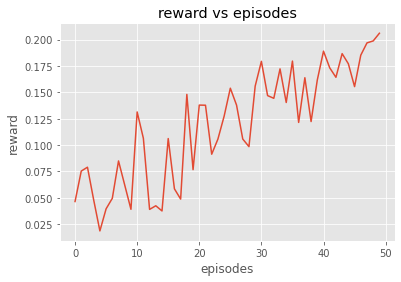

In [112]:
plot(reward_lis)

In [113]:
from tensorforce.agents import Agent
from tensorforce.execution import Runner
agent = Agent.create(
    agent='tensorforce', environment=environment, update=64,
    optimizer=dict(optimizer='adam', learning_rate=1e-3),
    objective='policy_gradient', reward_estimation=dict(horizon=20)
)

reward_lis = []
for i in tqdm(range(50)):
    states = environment.reset()
    terminal = False
    reward_epi = []
    while not terminal:
        actions = agent.act(states=states)
        states, terminal, reward = environment.execute(actions=actions)
        reward_epi.append(reward)
        agent.observe(terminal=terminal, reward=reward)
  

    reward_lis.append(mean(reward_epi))
    

100%|██████████| 50/50 [01:20<00:00,  1.60s/it]


mean reward : 0.4045498377024124


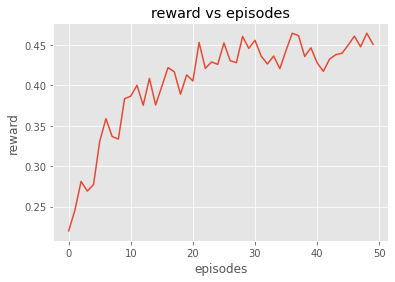

In [114]:
plot(reward_lis)

In [115]:
agent.save(directory='saved_model_DQN')

'saved_model_DQN/agent-1'

mean reward : 0.47851054109033136


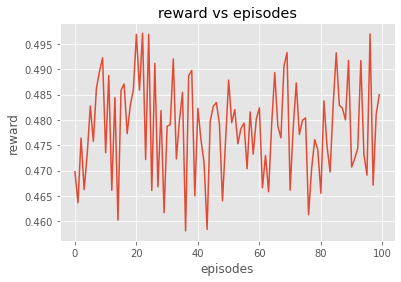

In [116]:
# evaluate agent on val and test datasets
def eval(agent, environment):
    reward_lis = []
    for _ in range(100):
        states = environment.reset()
        internals = agent.initial_internals()
        terminal = False
        reward_epi = []
        while not terminal:
            actions, internals = agent.act(
                states=states, internals=internals,
                independent=True, deterministic=True
            )
            states, terminal, reward = environment.execute(actions=actions)
            reward_epi.append(reward)
        reward_lis.append(mean(reward_epi))
    return reward_lis

reward_lis = eval(agent, environment)
plot(reward_lis)


In [ ]:
# agent = Agent.load(directory = 'saved_model_stochastic')
# environment = Environment.create(
#     environment=HelpdeskEnv('dataset/preprocessed/helpdesk_test_RL.pkl'), max_episode_timesteps=100
# )
# # val
# reward_lis = eval(agent, environment)
# plot(reward_lis)
